In [1]:
import dask.dataframe as dd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')

In [3]:
%%time

# set parquet data folder path
parquet_data_folder = '../data/crimes-2001-to-present.snappy.parq'
print('Loading crime data from: {}'.format(parquet_data_folder))

# load crimes parquet data into dask df
crimes = dd.read_parquet(parquet_data_folder, index='Date')

# load all data into memory
crimes = crimes.persist()
print('Crime data loaded into memory.')

Loading crime data from: ../data/crimes-2001-to-present.snappy.parq
Crime data loaded into memory.
Wall time: 10.6 s


In [4]:
# get homicides stats
crime_types = crimes[['PrimaryType']]
homicides = crime_types[(crime_types['PrimaryType']=='HOMICIDE')]
print(homicides.resample('M').count().compute())

            PrimaryType
2001-01-31           42
2001-02-28           26
2001-03-31           37
2001-04-30           59
2001-05-31           42
2001-06-30           68
2001-07-31           78
2001-08-31           56
2001-09-30           70
2001-10-31           69
2001-11-30           61
2001-12-31           49
2002-01-31           44
2002-02-28           31
2002-03-31           41
2002-04-30           43
2002-05-31           51
2002-06-30           65
2002-07-31           67
2002-08-31           77
2002-09-30           67
2002-10-31           57
2002-11-30           38
2002-12-31           70
2003-01-31           37
2003-02-28           31
2003-03-31           52
2003-04-30           57
2003-05-31           59
2003-06-30           51
...                 ...
2015-03-31           32
2015-04-30           35
2015-05-31           48
2015-06-30           48
2015-07-31           53
2015-08-31           53
2015-09-30           65
2015-10-31           32
2015-11-30           39
2015-12-31      

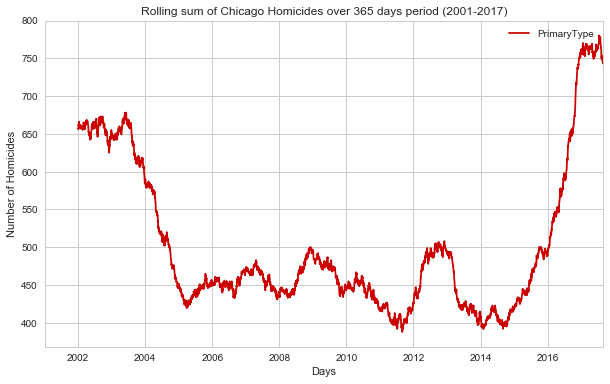

In [5]:
# get crimes rolling sum for a smoother crime chart display
crimes_rolling_sum = homicides.resample('D').count().rolling(365).sum().compute()
crimes_rolling_sum.plot(figsize=(10,6), color='#cc0000')
plt.title('Rolling sum of Chicago Homicides over 365 days period (2001-2017)')
plt.xlabel('Days')
plt.ylabel('Number of Homicides')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()